# international_migration_flow

This note works to produce the dataset t be put in Mapineq database  
Source: Meta  
Publisher: HDX (https://data.humdata.org/dataset/international-migration-flows)   
New York Times Article: https://www.nytimes.com/interactive/2025/04/17/opinion/global-migration-facebook-data.html   
Special countries: BA, UA, XK, UK/GB, EL/GR 

In [1]:
import os
import gc
import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
from pathlib import Path
import dask_geopandas as dgpd
from osgeo import gdal, osr
from rasterstats import zonal_stats

BASE_DIR = Path('/Users/wenlanzhang/PycharmProjects/Mapineq/src/data-wrangling/')
DATA_DIR = Path('/Users/wenlanzhang/Downloads/PhD_UCL/Data/Oxford')

# Load NTUS

In [2]:
# Load a GeoJSON file
gdf_2024 = gpd.read_file(DATA_DIR/"NUTS/NUTS_RG_01M_2024_3035.geojson")

gdf_country_2024 = gdf_2024[gdf_2024['LEVL_CODE'] == 0]
gdf_country_2024 = gdf_country_2024[['CNTR_CODE', 'geometry']].reset_index(drop=True)
# gdf_country_2024

gdf_2021 = gpd.read_file(DATA_DIR/"NUTS/NUTS_RG_01M_2021_3035.geojson")

gdf_country_2021 = gdf_2021[gdf_2021['LEVL_CODE'] == 0]
gdf_country_2021 = gdf_country_2021[['CNTR_CODE', 'geometry']].reset_index(drop=True)
uk_2021 = gdf_country_2021[gdf_country_2021['CNTR_CODE'] == 'UK']
# uk_2021

# Concatenate with 2024 data
gdf_country = pd.concat(
    [gdf_country_2024, uk_2021],
    ignore_index=True  # Reset index
)
# gdf_country

NUTS_country_list = gdf_country['CNTR_CODE'].unique()
# len(NUTS_country_list)
# NUTS_country_list
gdf_country

,CNTR_CODE,geometry
0,EL,"MULTIPOLYGON (((6083881.558 1676236.011, 60838..."
1,ES,"MULTIPOLYGON (((3815056.85 1904971.998, 381575..."
2,FI,"MULTIPOLYGON (((4999905.463 5305310.537, 50031..."
3,FR,"MULTIPOLYGON (((9980485.23 -3029930.054, 99812..."
4,HR,"MULTIPOLYGON (((4809521.18 2624665.768, 480963..."
5,EE,"MULTIPOLYGON (((5200614.71 4159725.901, 520083..."
6,DE,"MULTIPOLYGON (((4355225.354 2715902.995, 43548..."
7,DK,"MULTIPOLYGON (((4650283.775 3591676.53, 465057..."
8,BA,"MULTIPOLYGON (((4866544.51 2485914.128, 486624..."
9,AT,"MULTIPOLYGON (((4354847.685 2714710.627, 43552..."


In [3]:
NUTS_country_list

array(['EL', 'ES', 'FI', 'FR', 'HR', 'EE', 'DE', 'DK', 'BA', 'AT', 'BG',
       'CH', 'CY', 'BE', 'CZ', 'AL', 'LU', 'LV', 'ME', 'IE', 'IS', 'IT',
       'MK', 'MT', 'LI', 'NL', 'LT', 'HU', 'RS', 'SE', 'SI', 'TR', 'UA',
       'SK', 'RO', 'NO', 'PL', 'PT', 'XK', 'UK'], dtype=object)

# Load Country Centrality

In [4]:
Countries_Centrality_df = pd.read_csv(DATA_DIR/f"Countries_Centrality.csv") 
Countries_Centrality_df['country'] = Countries_Centrality_df['country'].replace({
    'GB': 'UK',    # UK name for Great Britain
    'GR': 'EL',    # Standardize Greece code
})

# Add South Sudan to country_coords
ss_row = pd.DataFrame([{
    'country': 'SS',
    'latitude': 6.8770,        # Approximate central lat
    'longitude': 31.3070,      # Approximate central lon
    'name': 'South Sudan'
}])

Countries_Centrality_df = pd.concat([Countries_Centrality_df, ss_row], ignore_index=True)
Countries_Centrality_df

,country,latitude,longitude,name
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.939110,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla
...,...,...,...,...
241,YT,-12.827500,45.166244,Mayotte
242,ZA,-30.559482,22.937506,South Africa
243,ZM,-13.133897,27.849332,Zambia
244,ZW,-19.015438,29.154857,Zimbabwe


# Load Migration

In [5]:
df = pd.read_csv(DATA_DIR/f"Migration/international_migration_flow.csv") 
df['year'] = pd.to_datetime(df['migration_month']).dt.year
df['month'] = pd.to_datetime(df['migration_month']).dt.month

# Define the mapping of old codes to new codes
country_code_mapping = {
    'GR': 'EL',  # Greece (GR → EL)
    'GB': 'UK'   # United Kingdom (GB → UK)
}

# Apply the replacement to both columns
df['country_from'] = df['country_from'].replace(country_code_mapping)
df['country_to'] = df['country_to'].replace(country_code_mapping)

df
# len(df['country_from'].unique())

,country_from,country_to,migration_month,num_migrants,year,month
0,AD,AE,2019-01,12,2019,1
1,AD,AE,2019-02,2,2019,2
2,AD,AE,2019-03,1,2019,3
3,AD,AE,2019-04,7,2019,4
4,AD,AE,2019-05,0,2019,5
...,...,...,...,...,...,...
1563149,ZW,ZM,2022-08,138,2022,8
1563150,ZW,ZM,2022-09,162,2022,9
1563151,ZW,ZM,2022-10,149,2022,10
1563152,ZW,ZM,2022-11,104,2022,11


In [6]:
df.sort_values(by='num_migrants', ascending=False).head(5)

,country_from,country_to,migration_month,num_migrants,year,month
1439985,UA,PL,2022-05,163937,2022,5
1435617,UA,DE,2022-05,135903,2022,5
647937,IN,AE,2022-02,129439,2022,2
1439986,UA,PL,2022-06,112254,2022,6
1435618,UA,DE,2022-06,109050,2022,6


In [7]:
# UK seasonal work visa
UK1907_inflow = df[(df['country_to'] == 'UK') & (df['year'] == 2019) & (df['month'] == 7)]
UK1910_inflow = df[(df['country_to'] == 'UK') & (df['year'] == 2019) & (df['month'] == 10)]
UK2210_inflow = df[(df['country_to'] == 'UK') & (df['year'] == 2022) & (df['month'] == 10)]

# Covid
DE2007_inflow = df[(df['country_to'] == 'DE') & (df['year'] == 2020) & (df['month'] == 7)]
UK2007_inflow = df[(df['country_to'] == 'UK') & (df['year'] == 2020) & (df['month'] == 7)]

# DE Ukraine
DE1905_inflow = df[(df['country_to'] == 'DE') & (df['year'] == 2019) & (df['month'] == 5)]
DE2205_inflow = df[(df['country_to'] == 'DE') & (df['year'] == 2022) & (df['month'] == 5)]

# UK2211_inflow[UK2211_inflow['num_migrants'] == UK2211_inflow['num_migrants'].max()]

In [8]:
def merge_with_coordinates_and_save(inflow_df, countries_df, output_filename):
    # Merge for source country (country_from)
    merged_df = pd.merge(
        inflow_df,
        countries_df[['country', 'latitude', 'longitude']],
        left_on='country_from',
        right_on='country',
        how='left'
    ).rename(columns={'latitude': 'source_lat', 'longitude': 'source_lon'}).drop(columns='country')

    merged_df = merged_df.drop(columns=['migration_month'])

    # Merge for target country (country_to)
    merged_df = pd.merge(
        merged_df,
        countries_df[['country', 'latitude', 'longitude']],
        left_on='country_to',
        right_on='country',
        how='left'
    ).rename(columns={'latitude': 'target_lat', 'longitude': 'target_lon'}).drop(columns='country')
    
    # Save to CSV
    merged_df.to_csv(output_filename, index=False)
    
    return merged_df

In [10]:
# UK
merged_UK1907 = merge_with_coordinates_and_save(
    UK1907_inflow, 
    Countries_Centrality_df, 
    DATA_DIR / 'Migration/Data4plot/UK1907_inflow.csv'
)

merged_UK1910 = merge_with_coordinates_and_save(
    UK1910_inflow, 
    Countries_Centrality_df, 
    DATA_DIR / 'Migration/Data4plot/UK1910_inflow.csv'
)
merged_UK2007 = merge_with_coordinates_and_save(
    UK2007_inflow, 
    Countries_Centrality_df, 
    DATA_DIR / 'Migration/Data4plot/UK2007_inflow.csv'
)
merged_UK2210 = merge_with_coordinates_and_save(
    UK2210_inflow, 
    Countries_Centrality_df, 
    DATA_DIR / 'Migration/Data4plot/UK2210_inflow.csv'
)


# DE
merged_DE1905 = merge_with_coordinates_and_save(
    DE1905_inflow, 
    Countries_Centrality_df, 
    DATA_DIR / 'Migration/Data4plot/DE1905_inflow.csv'
)
merged_DE2007 = merge_with_coordinates_and_save(
    DE2007_inflow, 
    Countries_Centrality_df, 
    DATA_DIR / 'Migration/Data4plot/DE2007_inflow.csv'
)
merged_DE2205 = merge_with_coordinates_and_save(
    DE2205_inflow, 
    Countries_Centrality_df, 
    DATA_DIR / 'Migration/Data4plot/DE2205_inflow.csv'
)

In [11]:
# ----------------------- calculate line width ------------------------
# Define all your merged DataFrames in a dictionary
datasets = {
    'UK1907': merged_UK1907,
    'UK1910': merged_UK1910,
    'UK2007': merged_UK2007,
    'UK2210': merged_UK2210,
    'DE1905': merged_DE1905,
    'DE2007': merged_DE2007,
    'DE2205': merged_DE2205
}


# Step 1: Extract max num_migrants per dataset
max_migrants = {key: df['num_migrants'].max() for key, df in datasets.items()}

# Step 2: Normalize against global max
global_max = max(max_migrants.values())
normalized = {key: val / global_max for key, val in max_migrants.items()}

# Step 3: Map to line width range
min_width = 0
max_width = 100

line_widths = {
    key: norm_val * (max_width - min_width) + min_width
    for key, norm_val in normalized.items()
}

# Print the results
for key in datasets:
    print(f"{key}: max={max_migrants[key]}, norm={normalized[key]:.2f}, linewidth={line_widths[key]:.2f}")


UK1907: max=7453, norm=0.05, linewidth=5.48
UK1910: max=11404, norm=0.08, linewidth=8.39
UK2007: max=1188, norm=0.01, linewidth=0.87
UK2210: max=45231, norm=0.33, linewidth=33.28
DE1905: max=4440, norm=0.03, linewidth=3.27
DE2007: max=1127, norm=0.01, linewidth=0.83
DE2205: max=135903, norm=1.00, linewidth=100.00


In [12]:
merged_UK2210['num_migrants'].sum()

np.int64(199015)

In [25]:
merged_UK2210[merged_UK2210['country_from'] == 'NG']

,country_from,country_to,num_migrants,year,month,source_lat,source_lon,target_lat,target_lon
118,NG,UK,29830,2022,10,9.081999,8.675277,55.378051,-3.435973


In [27]:
29830/199015

0.14988819938195613

In [26]:
# merged_UK1910['num_migrants'].sum()
merged_UK2210['num_migrants'].sum()

np.int64(199015)

In [18]:
df[(df['country_from'] == 'IN') & (df['country_to'] == 'UK') & (df['year'] == 2022)]

,country_from,country_to,migration_month,num_migrants,year,month
650576,IN,UK,2022-01,14503,2022,1
650577,IN,UK,2022-02,24622,2022,2
650578,IN,UK,2022-03,19862,2022,3
650579,IN,UK,2022-04,25098,2022,4
650580,IN,UK,2022-05,17272,2022,5
650581,IN,UK,2022-06,11582,2022,6
650582,IN,UK,2022-07,13735,2022,7
650583,IN,UK,2022-08,13398,2022,8
650584,IN,UK,2022-09,16611,2022,9
650585,IN,UK,2022-10,45231,2022,10


In [24]:
# df[(df['country_from'] == 'IN') & (df['country_to'] == 'UK') & (df['year'] == 2022) & (df['month'] == 10)]
df[(df['country_to'] == 'UK') & (df['year'] == 2022) & (df['month'] == 10)]

,country_from,country_to,migration_month,num_migrants,year,month
2685,AD,UK,2022-10,3,2022,10
11325,AE,UK,2022-10,1760,2022,10
19965,AF,UK,2022-10,602,2022,10
28603,AL,UK,2022-10,3454,2022,10
37243,AM,UK,2022-10,33,2022,10
...,...,...,...,...,...,...
1522735,XK,UK,2022-10,92,2022,10
1531327,YE,UK,2022-10,24,2022,10
1539967,ZA,UK,2022-10,2987,2022,10
1548607,ZM,UK,2022-10,226,2022,10


In [22]:
45231/199015

0.22727432605582493

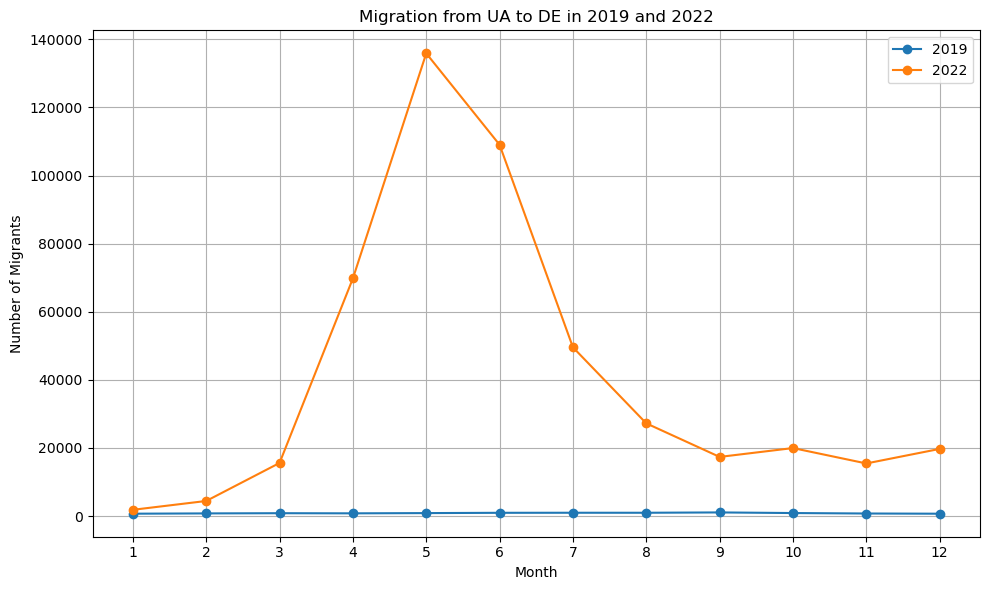

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter for UA to DE
ua_de_df = df[(df['country_from'] == 'UA') & (df['country_to'] == 'DE')]

# Ensure 'month' column is integer and sorted
ua_de_df = ua_de_df.sort_values(by=['year', 'month'])

# Split into 2019 and 2022 data
df_2019 = ua_de_df[ua_de_df['year'] == 2019]
df_2022 = ua_de_df[ua_de_df['year'] == 2022]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_2019['month'], df_2019['num_migrants'], marker='o', label='2019')
plt.plot(df_2022['month'], df_2022['num_migrants'], marker='o', label='2022')

plt.title('Migration from UA to DE in 2019 and 2022')
plt.xlabel('Month')
plt.ylabel('Number of Migrants')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


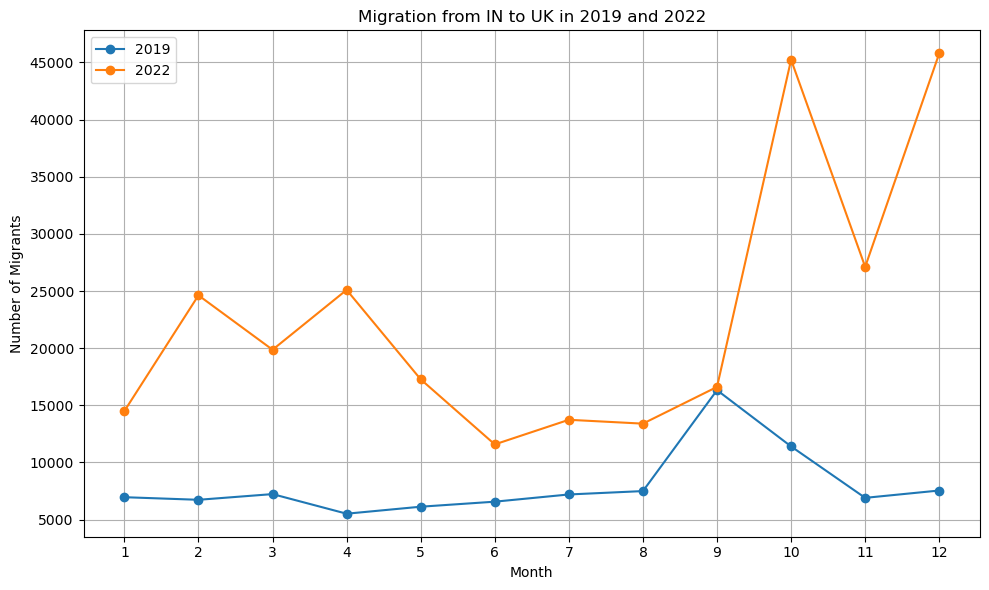

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter for UA to DE
ua_de_df = df[(df['country_from'] == 'IN') & (df['country_to'] == 'UK')]

# Ensure 'month' column is integer and sorted
ua_de_df = ua_de_df.sort_values(by=['year', 'month'])

# Split into 2019 and 2022 data
df_2019 = ua_de_df[ua_de_df['year'] == 2019]
df_2022 = ua_de_df[ua_de_df['year'] == 2022]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_2019['month'], df_2019['num_migrants'], marker='o', label='2019')
plt.plot(df_2022['month'], df_2022['num_migrants'], marker='o', label='2022')

plt.title('Migration from IN to UK in 2019 and 2022')
plt.xlabel('Month')
plt.ylabel('Number of Migrants')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
